#### Preamble

In [6]:
## Misc
import pandas as pd
import sys 
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('..')

## Plotting packages
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "plotly_white"

## Modelling
### torch
import torch.nn as nn
import torch
torch.manual_seed(101)
from torch.utils.data import DataLoader

## local
from models import AR_Net, AR
#from models.LSTM import ShallowRegressionLSTM
from utils.losses import censored_poisson_negative_log_likelihood
from utils.dataloader import cyclical_encode

## Predicing using covariates (hour and week variable) at time t 

#### Function to load datasets

In [247]:
def create_dataset(target, forecast_lead, add_month=True, add_hour=True, add_day_of_week=True, add_year=True, train_start='2016-07-01 00:00:00', 
                   train_end = '2017-07-01 00:00:00', test_start='2017-07-01 00:00:30', test_end='2017-08-01 00:00:00', is_censored = 'False',
                   multiple_stations = False):
    
    ## Function to load data sets, add covariates and split into training and test set. Has option to censor the input data (arg. is_censored) and 
    ## has option to use several stations to predict demand of one station (arg. multiple_stations)

    ## Output: training set, test set, list of explanatory variables (features) and list of targets (target)
    
    ## TODO: add option for validation set

    target_var = target

    if (is_censored == True):
        df = pd.read_csv('../data/charging_session_count_1_to_30_censored_dynamic.csv', parse_dates=['Period'])
        df_test = df.copy()
            
        ## ATTEMPT: shift tau variable too
        df_test[target_var + '_TAU'] = df_test[target_var + '_TAU'].shift(-forecast_lead)

        if (multiple_stations == True):
            
            ## keep data from other stations, the period and threshold tau for target variable
            features = [v for v in df_test.columns if target + '_TAU' in v]
            other_stations = [v for v in df_test.columns if '_TAU' not in v]
            features.extend(other_stations)

            df_test = df_test[features]

            ## Remove tau so it isnt and input feature
            features.remove(target + '_TAU')

        else:
            features = [v for v in df_test.columns if target in v]
            features.append('Period')
            df_test = df_test[features]

            print(features)
            ## Remove tau so it isnt and input feature
            features.remove(target + '_TAU')

    else:
        ## keep everything from input dataframe
        df = pd.read_csv('../data/charging_session_count_1_to_30.csv', parse_dates=['Period'])
        df_test = df.copy()
        features = df_test.columns.values

        if (multiple_stations == False):
            ## Keep only data from target station and the period 
            features = [station for station in df_test.columns if target in station]
            features.append('Period')
            df_test = df_test[features]

   

    if (type(train_end) != int):
        train_start = df_test[df_test['Period'] == train_start].index.values[0]
        train_end = df_test[df_test['Period'] == train_end].index.values[0]
        test_start = df_test[df_test['Period'] == test_start].index.values[0]
        test_end = df_test[df_test['Period'] == test_end].index.values[0]

    # Create target variable. We might have more targets if we're running 
    # multivariate models
    #features = list(df.columns.difference(['BRYANT', 'CAMBRIDGE', 'HAMILTON', 'HIGH', 'MPL', 'RINCONADA', 'TED']))
    #features = list(df.columns.difference([target_var]))
    
    forecast_lead = 24
    if isinstance(target_var, list):
        target = [f"{var}_lead{forecast_lead}" for var in target_var]
    else:
        target = f"{target_var}_lead{forecast_lead}"
    
    ## Shift target variable(s)
    df_test[target] = df_test[target_var].shift(-forecast_lead)
    df_test = df_test.iloc[:-forecast_lead]


    new_cols = []
    if add_month:
        df_test['month'] = df.Period.dt.month
        df_test, new_cols = cyclical_encode(df_test, 'month', 12)
        features.extend(new_cols)
        #features = features + new_cols
    if add_day_of_week:
        df_test['dayofweek'] = df.Period.dt.dayofweek
        df_test, new_cols = cyclical_encode(df_test, 'dayofweek', 7)
        features.extend(new_cols)
        #features = features + new_cols
    if add_hour:
        df_test['hour'] = df.Period.dt.hour
        df_test, new_cols = cyclical_encode(df_test, 'hour', 24)
        features.extend(new_cols)
        #features = features + new_cols
    if add_year:
        df_test['year'] = df.Period.dt.year - df.Period.dt.year.min()
        features.append('year')


    ## Create train/test set
    df_train = df_test.loc[train_start:train_end].copy()
    df_test = df_test.loc[test_start:test_end].copy()

    features.remove('Period')

    #print("Test set fraction:", len(df_test) / len(df_train))
    return df_train, df_test, features, target



#### Dataloader classes censored and uncensored modelling

In [123]:
from torch.utils.data import Dataset

class SequenceDatasetCensored(Dataset):
    ## Class to retrieve time series elements appropirately with CENSORED target variable y

    def __init__(self, dataframe, target, features, threshold, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()
        self.tau = torch.tensor(dataframe[threshold].values).float()
        
    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i):
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i], self.tau[i]
    
class SequenceDataset(Dataset):
    ## Class to retrieve time series elements appropirately with UNCENSORED target variable y

    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()
        
    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i):
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

#### Test data loader and data set classes

In [124]:
TRAIN_START = '2016-07-01 00:00:00'
TRAIN_END = '2016-08-01 00:00:00'
TEST_START = '2016-08-01 00:30:00'
TEST_END = '2016-08-08 00:00:00'

batch_size = 4
sequence_length = 72
target = 'WEBSTER'
threshold = 'WEBSTER_TAU'

df_train, df_test, features, target = create_dataset(
    target = 'WEBSTER',
    forecast_lead = 24,
    add_month = True, add_hour = True, add_day_of_week = True, add_year = True,
    train_start = TRAIN_START, train_end = TRAIN_END, test_start = TEST_START, test_end = TEST_END,
    is_censored = True, multiple_stations=False)


train_dataset = SequenceDatasetCensored(
    df_train,
    target=target,
    features=features,
    threshold=threshold,
    sequence_length=sequence_length
)

test_dataset = SequenceDatasetCensored(
    df_test,
    target=target,
    features=features,
    threshold=threshold,
    sequence_length=sequence_length
)

'''
train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)

test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)'''

## Use pytorch dataload to sequentially order data using the defined dataset classes
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y, tau = next(iter(train_loader))
#X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)
#print("Threshold shape:", tau.shape)

print(X[1,11,:])
print(y[1])
print(tau[1])
print(target)
print(features)

['WEBSTER', 'WEBSTER_TAU', 'Period']
Features shape: torch.Size([4, 72, 8])
Target shape: torch.Size([4])
tensor([ 2.0000, -0.5000, -0.8660,  0.4339, -0.9010, -0.8660, -0.5000,  5.0000])
tensor(2.)
tensor(2.)
WEBSTER_lead24
['WEBSTER', 'month_sin', 'month_cos', 'dayofweek_sin', 'dayofweek_cos', 'hour_sin', 'hour_cos', 'year']


In [125]:
df_train.head()

,WEBSTER,WEBSTER_TAU,Period,WEBSTER_lead24,month_sin,month_cos,dayofweek_sin,dayofweek_cos,hour_sin,hour_cos,year
86312,2.0,2.0,2016-07-01 00:00:00,2.0,-0.5,-0.866025,-0.433884,-0.900969,0.000000,1.000000,5
86313,2.0,2.0,2016-07-01 00:30:00,2.0,-0.5,-0.866025,-0.433884,-0.900969,0.000000,1.000000,5
86314,2.0,2.0,2016-07-01 01:00:00,2.0,-0.5,-0.866025,-0.433884,-0.900969,0.258819,0.965926,5
86315,2.0,2.0,2016-07-01 01:30:00,2.0,-0.5,-0.866025,-0.433884,-0.900969,0.258819,0.965926,5
86316,2.0,2.0,2016-07-01 02:00:00,2.0,-0.5,-0.866025,-0.433884,-0.900969,0.500000,0.866025,5


#### Training and test loops for CENSORED data. TODO: add validation loop

In [13]:
import torch.nn.functional as F

### Training and test function for censored data 
def train_model_censored(data_loader, model, loss_function, optimizer, verbose=True):
    num_batches = len(data_loader)
    total_loss = 0
    total_mse_loss = 0
    model.train()
    
    for X, y, tau in data_loader:
        output = model(X)

        loss = loss_function(output, y, tau)
        total_mse_loss += F.mse_loss(output, y).detach().numpy()


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    avg_mse_loss = total_mse_loss / num_batches
    if verbose:
        print(f"Train loss: {avg_loss}")
    return avg_loss, avg_mse_loss

def test_model_censored(data_loader, model, loss_function, verbose=True):
    num_batches = len(data_loader)
    total_loss = 0
    total_mse_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y, tau in data_loader:
            output = model(X)
            total_loss += loss_function(output, y, tau).item()
            total_mse_loss += F.mse_loss(output, y).detach().numpy()

    avg_loss = total_loss / num_batches
    avg_mse_loss = total_mse_loss / num_batches
    if verbose:
        print(f"Test loss: {avg_loss}")
    return avg_loss, avg_mse_loss

#### Training and test loops for UNCENSORED data. TODO: add validation loop

In [14]:
### Training and test function for uncensored data 
def train_model(data_loader, model, loss_function, optimizer, verbose=True):
    num_batches = len(data_loader)
    total_loss = 0
    total_mse_loss = 0
    model.train()
    
    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)
        total_mse_loss += F.mse_loss(output, y).detach().numpy()


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    avg_mse_loss = total_mse_loss / num_batches
    if verbose:
        print(f"Train loss: {avg_loss}")
    return avg_loss, avg_mse_loss

def test_model(data_loader, model, loss_function, verbose=True):
    num_batches = len(data_loader)
    total_loss = 0
    total_mse_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()
            total_mse_loss += F.mse_loss(output, y).detach().numpy()

    avg_loss = total_loss / num_batches
    avg_mse_loss = total_mse_loss / num_batches
    if verbose:
        print(f"Test loss: {avg_loss}")
    return avg_loss, avg_mse_loss

#### Functions to predict CENSORED and UNCENSORED data

In [15]:
def predict_censored(data_loader, model):
    ## Input: data loader object and trained model

    ## Output: predictions on unseen data

    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, y_out, tau in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    
    return output

In [16]:
def predict(data_loader, model):
    ## Input: data loader object and trained model

    ## Output: predictions on unseen data

    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    
    return output

# Uncensored experiments

### AR

In [164]:
batch_size = 4
sequence_length = 72
target = 'WEBSTER'
threshold = 'WEBSTER_TAU'

TRAIN_START = '2016-07-01 00:00:00'
TRAIN_END = '2016-08-01 00:00:00'
TEST_START = '2016-08-01 00:30:00'
TEST_END = '2016-08-08 00:00:00'


df_train, df_test, features, target = create_dataset(
    target = target,
    forecast_lead = 24,
    add_month = True, add_hour = True, add_day_of_week = True, add_year = True,
    train_start = TRAIN_START, train_end = TRAIN_END, test_start = TEST_START, test_end = TEST_END,
    is_censored = False, multiple_stations=False)

In [165]:
train_dataset_ar = SequenceDataset(
    df_train,
    target=target,
    features=['WEBSTER'],
    sequence_length=sequence_length
)
test_dataset_ar = SequenceDataset(
    df_test,
    target=target,
    features=['WEBSTER'],
    sequence_length=sequence_length
)

train_loader_ar = DataLoader(train_dataset_ar, batch_size=batch_size, shuffle=True)
test_loader_ar = DataLoader(test_dataset_ar, batch_size=batch_size, shuffle=False)


model_ar = AR(sequence_length, 1)
loss_function = nn.PoissonNLLLoss(log_input=False)

optimizer = torch.optim.Adam(model_ar.parameters(), lr=0.001)

In [166]:

model_ar.train()
mse_train_loss_ar = []
mse_test_loss_ar = []
for ix_epoch in range(10):
    print(f"Epoch {ix_epoch}\n---------")
    poisson_train_ar, mse_train_ar = train_model(train_loader_ar, model_ar, loss_function, optimizer=optimizer)
    poisson_test_ar, mse_test_ar = test_model(test_loader_ar, model_ar, loss_function)
    mse_train_loss_ar.append(mse_train_ar)
    mse_test_loss_ar.append(mse_test_ar)
    #print()

Epoch 0
---------


/var/folders/zw/yys6vm7506q010fwbsz_3djr0000gn/T/ipykernel_913/1443511223.py:11: UserWarning:

Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

/var/folders/zw/yys6vm7506q010fwbsz_3djr0000gn/T/ipykernel_913/1443511223.py:11: UserWarning:

Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

/var/folders/zw/yys6vm7506q010fwbsz_3djr0000gn/T/ipykernel_913/1443511223.py:36: UserWarning:

Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Train loss: -0.7805826522150244
Test loss: -1.281846856077512
Epoch 1
---------
Train loss: -1.0262822860367495
Test loss: -1.3467415707806747
Epoch 2
---------
Train loss: -1.1296611329385806
Test loss: -1.3510573706811382
Epoch 3
---------
Train loss: -1.161885689384736
Test loss: -1.4516851706873803
Epoch 4
---------
Train loss: -1.1896731484551533
Test loss: -1.2893303258433229
Epoch 5
---------
Train loss: -1.199960696074023
Test loss: -1.4095526384633212
Epoch 6
---------
Train loss: -1.198192029851851
Test loss: -1.4653396876972347
Epoch 7
---------
Train loss: -1.2174293492738426
Test loss: -1.4735843478923751
Epoch 8
---------
Train loss: -1.2446836221753432
Test loss: -1.5136555991179885
Epoch 9
---------
Train loss: -1.1963852313184866
Test loss: -1.540234748983667


#### Store results in array

In [129]:
train_eval_loader_ar = DataLoader(train_dataset_ar, batch_size=batch_size, shuffle=False)

ystar_col = "AR"
df_train[ystar_col] = predict(train_eval_loader_ar, model_ar).numpy()
df_test[ystar_col] = predict(test_loader_ar, model_ar).numpy()

df_out = pd.concat((df_train, df_test))[[target, ystar_col]]

#### AR with hidden unit

In [130]:
model_ar_net = AR_Net(sequence_length, output_dim=1,hidden_dim=50)
loss_function = nn.PoissonNLLLoss(log_input=False)
optimizer = torch.optim.Adam(model_ar_net.parameters(), lr=0.001)

In [168]:
model_ar_net.train()
mse_train_loss_ar_net = []
mse_test_loss_ar_net = []
for ix_epoch in range(10):
    print(f"Epoch {ix_epoch}\n---------")
    poisson_train_ar_net, mse_train_ar_net = train_model(train_loader_ar, model_ar_net, loss_function, optimizer=optimizer, verbose=False)
    poisson_test_ar_net, mse_test_ar_net = test_model(test_loader_ar, model_ar_net, loss_function, verbose=False)
    mse_train_loss_ar_net.append(mse_train_ar_net)
    mse_test_loss_ar_net.append(mse_test_ar_net)

Epoch 0
---------


/var/folders/zw/yys6vm7506q010fwbsz_3djr0000gn/T/ipykernel_913/1443511223.py:11: UserWarning:

Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

/var/folders/zw/yys6vm7506q010fwbsz_3djr0000gn/T/ipykernel_913/1443511223.py:11: UserWarning:

Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

/var/folders/zw/yys6vm7506q010fwbsz_3djr0000gn/T/ipykernel_913/1443511223.py:36: UserWarning:

Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Epoch 1
---------
Epoch 2
---------
Epoch 3
---------
Epoch 4
---------
Epoch 5
---------
Epoch 6
---------
Epoch 7
---------
Epoch 8
---------
Epoch 9
---------


In [132]:
#train_eval_loader_ar = DataLoader(train_dataset_ar, batch_size=batch_size, shuffle=False)

ystar_col = "AR-Net"
model_ar_net.eval()
df_train[ystar_col] = predict(train_eval_loader_ar, model_ar_net).numpy()
df_test[ystar_col] = predict(test_loader_ar, model_ar_net).numpy()

df_out[ystar_col] = pd.concat((df_train, df_test))[[ystar_col]]

In [133]:
plot_template = dict(
    layout=go.Layout({
        "font_size": 12,
        "xaxis_title_font_size": 14,
        "yaxis_title_font_size": 14})
)

fig = px.line(df_out[100:], labels=dict(created_at="Date", value="Sessions"))
fig.add_vline(x=TEST_START, line_width=4, line_dash="dash")
fig.add_annotation(xref="paper", x=0.75, yref="paper", y=1.02, text="Test set start", showarrow=False)
fig.update_layout(
    template=plot_template, legend=dict(orientation='h', y=1.02, title_text="")
)
fig.show()

#### LSTM multivariate uncensored

In [169]:
class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)
        
        #self.activation = nn.Sigmoid()

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        
        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.
        #out = self.activation(out)

        return out.exp()

        #return out

In [170]:
learning_rate =5e-4
num_hidden_units = 16
batch_size = 4
sequence_length = 72
target = 'WEBSTER'
threshold = 'WEBSTER_TAU'

TRAIN_START = '2016-07-01 00:00:00'
TRAIN_END = '2016-08-01 00:00:00'
TEST_START = '2016-08-01 00:30:00'
TEST_END = '2016-08-08 00:00:00'

# Load dataset using covariates
df_train, df_test, features, target = create_dataset(
    target = target,
    forecast_lead = 24,
    add_month = True, add_hour = True, add_day_of_week = True, add_year = True,
    train_start = TRAIN_START, train_end = TRAIN_END, test_start = TEST_START, test_end = TEST_END,
    is_censored = False, multiple_stations=False)

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = ShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units)
loss_function = nn.PoissonNLLLoss(log_input = False)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [171]:
mse_train_loss_lstm = []
mse_test_loss_lstm = []

for ix_epoch in range(5):
    print(f"Epoch {ix_epoch}\n---------")
    poisson_train_lstm, mse_train_lstm = train_model(train_loader, model, loss_function, optimizer=optimizer)
    poisson_test_lstm, mse_test_lstm = test_model(test_loader, model, loss_function)
    mse_train_loss_lstm.append(mse_train_lstm)
    mse_test_loss_lstm.append(mse_test_lstm)
    print()


Epoch 0
---------
Train loss: -1.2329601111744428
Test loss: -1.7827542232615607

Epoch 1
---------
Train loss: -1.6247780463650783
Test loss: -1.8340339667740322

Epoch 2
---------
Train loss: -1.6479674707149372
Test loss: -1.8323207884317352

Epoch 3
---------
Train loss: -1.6515362362599564
Test loss: -1.8135098084097816

Epoch 4
---------
Train loss: -1.6633660268368096
Test loss: -1.8293679711364565



In [137]:
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col = "LSTM"
df_train[ystar_col] = predict(train_eval_loader, model).numpy()
df_test[ystar_col] = predict(test_loader, model).numpy()

df_out[ystar_col] = pd.concat((df_train, df_test))[ystar_col]


In [138]:
plot_template = dict(
    layout=go.Layout({
        "font_size": 12,
        "xaxis_title_font_size": 14,
        "yaxis_title_font_size": 14})
)

test_index = df_test[df_test['Period'] == TEST_START].index.values[0]

fig = px.line(df_out[100:], labels=dict(created_at="Date", value="Sessions"))
fig.add_vline(x=test_index, line_width=4, line_dash="dash")
fig.add_annotation(xref="paper", x=0.85, yref="paper", y=1.04, text="Test set start", showarrow=False)
fig.update_layout(
    template=plot_template, legend=dict(orientation='h', y=1.06, title_text="")
)
fig.show()

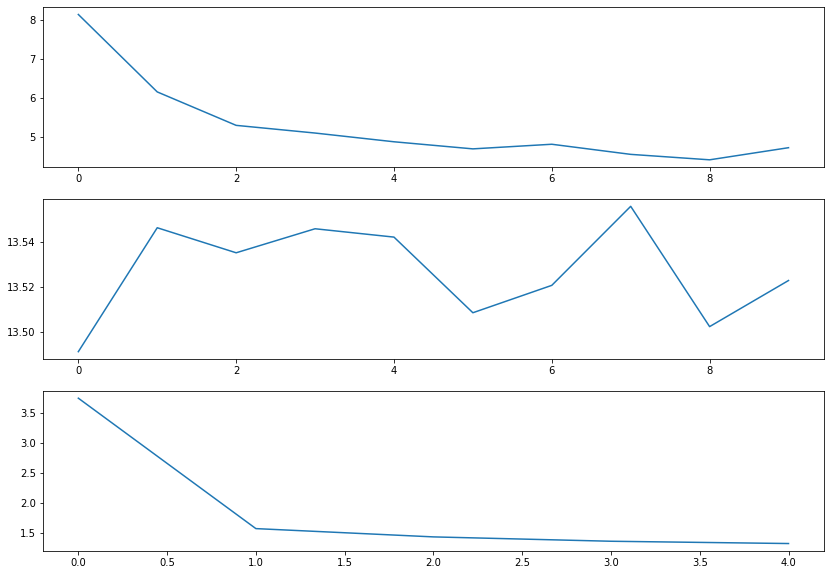

In [176]:
## Losses
fig, ax = plt.subplots(3, figsize=(14,10))
ax[0].plot(mse_train_loss_ar)
ax[1].plot(mse_train_loss_ar_net)
ax[2].plot(mse_train_loss_lstm)


#### Loss functions for censored regression

In [248]:
from scipy.stats import poisson
def poisson_cdf(k, lamb):
    cdf = 0
    k_int = int(np.ceil(k))
    for i in range(k_int + 1):
        cdf += (lamb ** i) * torch.exp(-lamb) / torch.factorial(i)
    return cdf

def poisson_negative_log_likelihood(y_predict, y):
    pois = torch.distributions.poisson.Poisson(y_predict)
    return (- torch.sum(pois.log_prob(y)))

def censored_poisson_negative_log_likelihood_v2(y_predict, y, C):
    """ 
    y_predict: lambda for Poisson
    y: observed data
    C: censoring threshold
    https://findit.dtu.dk/en/catalog/53282c10c18e77205dd0f8ae """

    pois = torch.distributions.poisson.Poisson(y_predict)

    # Pytorch doesn't have the cdf function for the poisson distribution
    poiss_cdf = 1 - torch.tensor(poisson.cdf(k=4, mu=y_predict.detach().numpy()))

    d_t = (C > y).int()

    return -torch.sum((d_t * pois.log_prob(y)) + ((1-d_t) * (torch.log(poiss_cdf)))) #Do we sum on the correct axis here?


'''
def censored_normal_NLL(y_predict, y, C):
    gauss_pdf = torch.distributions.normal.Normal(y_predict)
    gauss_cdf = torch.


    return -torch.sum((d_t * pois.log_prob(y)) + ((1-d_t) * (1-torch.log(poiss_cdf)))) '''

'\ndef censored_normal_NLL(y_predict, y, C):\n    gauss_pdf = torch.distributions.normal.Normal(y_predict)\n    gauss_cdf = torch.\n\n\n    return -torch.sum((d_t * pois.log_prob(y)) + ((1-d_t) * (1-torch.log(poiss_cdf)))) '

In [249]:
learning_rate =5e-4
num_hidden_units = 16
batch_size = 4
sequence_length = 72
target = 'WEBSTER'
threshold = 'WEBSTER_TAU'

df_train, df_test, features, target = create_dataset(
    target = 'WEBSTER',
    forecast_lead = 24,
    add_month = True, add_hour = True, add_day_of_week = True, add_year = True,
    train_start = TRAIN_START, train_end = TRAIN_END, test_start = TEST_START, test_end = TEST_END,
    is_censored = True, multiple_stations=False)

train_dataset = SequenceDatasetCensored(
    df_train,
    target=target,
    features=['WEBSTER'],
    threshold=threshold,
    sequence_length=sequence_length
)

test_dataset = SequenceDatasetCensored(
    df_test,
    target=target,
    features=['WEBSTER'],
    threshold=threshold,
    sequence_length=sequence_length
)

['WEBSTER', 'WEBSTER_TAU', 'Period']


In [250]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y, tau = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)
print("Threshold shape:", tau.shape)

print(X[1,11,:])
print(y[1])
print(tau[1])
print(target)

Features shape: torch.Size([4, 72, 1])
Target shape: torch.Size([4])
Threshold shape: torch.Size([4])
tensor([5.])
tensor(2.)
tensor(5.)
WEBSTER_lead24


#### AR

In [251]:
model_ar = AR(sequence_length, 1)
loss_function = censored_poisson_negative_log_likelihood_v2
optimizer = torch.optim.Adam(model_ar.parameters(), lr=0.00001)

In [252]:
model_ar.train()
mse_train_loss_ar_censored = []
mse_test_loss_ar_censored = []

for ix_epoch in range(10):
    print(f"Epoch {ix_epoch}\n---------")
    poisson_train_ar_censored, mse_train_ar_censored = train_model_censored(train_loader, model_ar, loss_function, optimizer=optimizer)
    poisson_test_ar_censored, mse_test_ar_censored = test_model_censored(test_loader, model_ar, loss_function)
    mse_train_loss_ar_censored.append(mse_train_ar_censored)
    mse_test_loss_ar_censored.append(mse_test_ar_censored)

    
    #print()

Epoch 0
---------


/var/folders/zw/yys6vm7506q010fwbsz_3djr0000gn/T/ipykernel_913/3115374496.py:14: UserWarning:

Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

/var/folders/zw/yys6vm7506q010fwbsz_3djr0000gn/T/ipykernel_913/3115374496.py:14: UserWarning:

Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

/var/folders/zw/yys6vm7506q010fwbsz_3djr0000gn/T/ipykernel_913/3115374496.py:39: UserWarning:

Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Train loss: 122.87485163972954
Test loss: 104.68717595254962
Epoch 1
---------
Train loss: 85.27227854007745
Test loss: 69.67915525208637
Epoch 2
---------
Train loss: 57.81274992856621
Test loss: 47.50467134782516
Epoch 3
---------
Train loss: 42.595656489849034
Test loss: 37.78633693414098
Epoch 4
---------
Train loss: 37.040930046382464
Test loss: 34.763959348400086
Epoch 5
---------
Train loss: 35.481263367877446
Test loss: 34.4066690083156
Epoch 6
---------
Train loss: 35.48112733667613
Test loss: 34.132637458080254
Epoch 7
---------
Train loss: 35.300552641319534
Test loss: 34.303364324376595
Epoch 8
---------
Train loss: 35.17913999018541
Test loss: 34.350608399834535
Epoch 9
---------
Train loss: 34.931460990652475
Test loss: 34.57262749902062


In [253]:
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
ystar_col = "AR (aware)"
df_train[ystar_col] = predict_censored(train_eval_loader, model_ar).numpy()
df_test[ystar_col] = predict_censored(test_loader, model_ar).numpy()

df_out_censored = pd.concat((df_train, df_test))[[target, ystar_col]]

#### AR Net

In [254]:
model_ar_net = AR_Net(sequence_length, output_dim=1,hidden_dim=50)
loss_function = censored_poisson_negative_log_likelihood_v2
#loss_function = nn.PoissonNLLLoss(log_input=False)

optimizer = torch.optim.Adam(model_ar_net.parameters(), lr=0.00001)

In [255]:
model_ar_net.train()
mse_train_loss_ar_net_censored = []
mse_test_loss_ar_net_censored = []

for ix_epoch in range(10):
    print(f"Epoch {ix_epoch}\n---------")
    poisson_train_ar_net_censored, mse_train_ar_net_censored = train_model_censored(train_loader, model_ar_net, loss_function, optimizer=optimizer)
    poisson_test_ar_net_censored, mse_test_ar_net_censored = test_model_censored(test_loader, model_ar_net, loss_function)
    mse_train_loss_ar_net_censored.append(mse_train_ar_net_censored)
    mse_test_loss_ar_net_censored.append(mse_test_ar_net_censored)
    print()

Epoch 0
---------


/var/folders/zw/yys6vm7506q010fwbsz_3djr0000gn/T/ipykernel_913/3115374496.py:14: UserWarning:

Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

/var/folders/zw/yys6vm7506q010fwbsz_3djr0000gn/T/ipykernel_913/3115374496.py:14: UserWarning:

Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

/var/folders/zw/yys6vm7506q010fwbsz_3djr0000gn/T/ipykernel_913/3115374496.py:39: UserWarning:

Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Train loss: 36.46357717921027
Test loss: 36.07066338342234

Epoch 1
---------
Train loss: 34.47523451238729
Test loss: 35.32210393152553

Epoch 2
---------
Train loss: 33.866388230745976
Test loss: 35.0405041958179

Epoch 3
---------
Train loss: 33.635182746976554
Test loss: 33.70988019539617

Epoch 4
---------
Train loss: 33.00577657303937
Test loss: 32.81882319743512

Epoch 5
---------
Train loss: 32.79870856245422
Test loss: 33.698569705079436

Epoch 6
---------
Train loss: 32.635543408245404
Test loss: 33.74974752313126

Epoch 7
---------
Train loss: 32.560319387701625
Test loss: 33.37109143308802

Epoch 8
---------
Train loss: 32.8579325293937
Test loss: 32.75928355495855

Epoch 9
---------
Train loss: 32.442257063547146
Test loss: 32.65643566126746



In [256]:
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
ystar_col = "AR_Net (aware)"

df_train[ystar_col] = predict_censored(train_eval_loader, model_ar_net).numpy()
df_test[ystar_col] = predict_censored(test_loader, model_ar_net).numpy()

df_out_censored[ystar_col] = pd.concat((df_train, df_test))[ystar_col]

#### LSTM

In [257]:
learning_rate =5e-5
num_hidden_units = 16
batch_size = 4
sequence_length = 72
target = 'WEBSTER'
threshold = 'WEBSTER_TAU'

df_train, df_test, features, target = create_dataset(
    target = 'WEBSTER',
    forecast_lead = 24,
    add_month = True, add_hour = True, add_day_of_week = True, add_year = True,
    train_start = TRAIN_START, train_end = TRAIN_END, test_start = TEST_START, test_end = TEST_END,
    is_censored = True, multiple_stations=False)

train_dataset = SequenceDatasetCensored(
    df_train,
    target=target,
    features=features,
    threshold=threshold,
    sequence_length=sequence_length
)

test_dataset = SequenceDatasetCensored(
    df_test,
    target=target,
    features=features,
    threshold=threshold,
    sequence_length=sequence_length
)

['WEBSTER', 'WEBSTER_TAU', 'Period']


In [258]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model_lstm = ShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units)
loss_function = censored_poisson_negative_log_likelihood_v2
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=learning_rate)

In [259]:
mse_train_loss_lstm_censored = []
mse_test_loss_lstm_censored = []

for ix_epoch in range(5):
    print(f"Epoch {ix_epoch}\n---------")
    poisson_train_lstm_censored, mse_train_lstm_censored = train_model_censored(train_loader, model_lstm, loss_function, optimizer=optimizer)
    poisson_test_lstm_censored, mse_test_lstm_censored = test_model_censored(test_loader, model_lstm, loss_function)
    mse_train_loss_lstm_censored.append(mse_train_lstm_censored)
    mse_test_loss_lstm_censored.append(mse_test_lstm_censored)

    print()

Epoch 0
---------
Train loss: 12.322716187021399
Test loss: 12.04383190401425

Epoch 1
---------
Train loss: 10.966768668216355
Test loss: 10.611494067884408

Epoch 2
---------
Train loss: 9.659078488135643
Test loss: 9.442329220056799

Epoch 3
---------
Train loss: 8.727564105402234
Test loss: 8.602124777437043

Epoch 4
---------
Train loss: 8.078568087344866
Test loss: 8.065276904311776



In [260]:
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col = "LSTM (aware)"
df_train[ystar_col] = predict_censored(train_eval_loader, model).numpy()
df_test[ystar_col] = predict_censored(test_loader, model).numpy()

df_out_censored[ystar_col] = pd.concat((df_train, df_test))[ystar_col]


In [261]:
### Read actual observations to add to plot 
df_uncensored = pd.read_csv('../data/charging_session_count_1_to_30.csv', parse_dates=['Period'])
train_start_uncensored = df_uncensored[df_uncensored['Period'] == TRAIN_START].index.values[0] + 24
train_end_uncensored  = df_uncensored[df_uncensored['Period'] == TRAIN_END].index.values[0] + 24
test_start_uncensored  = df_uncensored[df_uncensored['Period'] == TEST_START].index.values[0] + 24
test_end_uncensored  = df_uncensored[df_uncensored['Period'] == TEST_END].index.values[0] + 26

df_out_censored['Uncensored observations'] = pd.concat((df_uncensored[train_start_uncensored:train_end_uncensored], 
                                               df_uncensored[test_start_uncensored:test_end_uncensored]))['WEBSTER'].values

df_out_censored.loc[df_out_censored['Uncensored observations'] < 4, 'Uncensored observations'] = 4

In [262]:
plot_template = dict(
    layout=go.Layout({
        "font_size": 12,
        "xaxis_title_font_size": 14,
        "yaxis_title_font_size": 14})
)

test_index = df_test[df_test['Period'] == TEST_START].index.values[0]

fig = px.line(df_out_censored[300:], labels=dict(created_at="Date", value="Sessions"))
fig.add_vline(x=test_index, line_width=4, line_dash="dash")
fig.add_annotation(xref="paper", x=0.85, yref="paper", y=-0.2, text="Test set start", showarrow=False)
fig.update_layout(
    template=plot_template, legend=dict(orientation='h', y=1.06, title_text="")
)
fig.show()

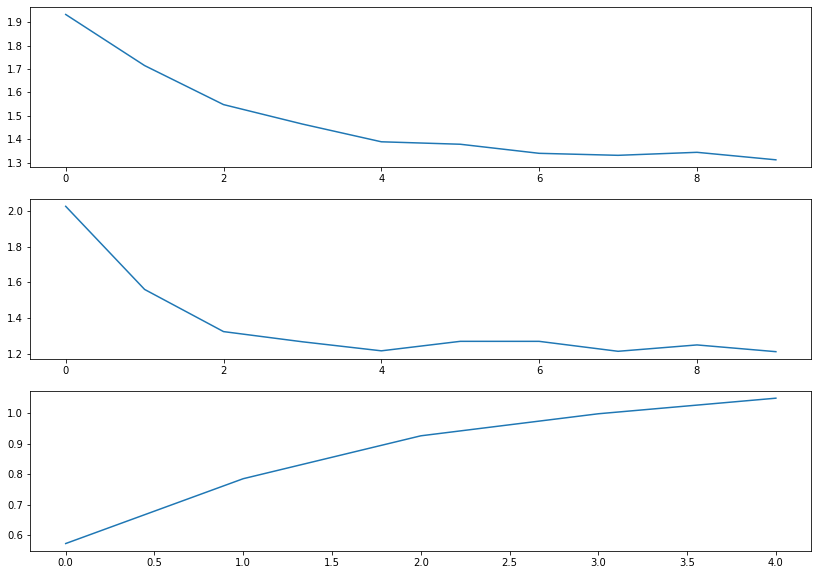

In [193]:
## Losses
fig, ax = plt.subplots(3, figsize=(14,10))
ax[0].plot(mse_train_loss_ar_censored)
ax[1].plot(mse_train_loss_ar_net_censored)
ax[2].plot(mse_train_loss_lstm_censored)

## Non censorship-aware

In [730]:
'''
learning_rate = 1e-4
num_hidden_units = 12
batch_size = 4
sequence_length = 72
target = 'WEBSTER'
threshold = 'WEBSTER_TAU'

learning_rate =1e-4
num_hidden_units = 32
batch_size = 4
sequence_length = 72
target = 'WEBSTER'
threshold = 'WEBSTER_TAU'

# Load dataset using covariates
df_train, df_test, features, target = create_dataset(
    target = target,
    forecast_lead = 24,
    add_month = True, add_hour = True, add_day_of_week = True, add_year = True,
    train_start = TRAIN_START, train_end = TRAIN_END, test_start = TEST_START, test_end = TEST_END,
    is_censored = True, multiple_stations=False)
'''

train_dataset = SequenceDatasetCensored(
    df_train,
    target=target,
    features=features,
    threshold=threshold,
    sequence_length=sequence_length
)
test_dataset = SequenceDatasetCensored(
    df_test,
    target=target,
    features=features,
    threshold=threshold,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = ShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units)
loss_function = nn.PoissonNLLLoss(log_input = False)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [731]:
for ix_epoch in range(10):
    print(f"Epoch {ix_epoch}\n---------")
    train_model(train_loader, model, loss_function, optimizer=optimizer)
    test_model(test_loader, model, loss_function)
    print()

Epoch 0
---------
Train loss: -0.06675342190698189
Test loss: -0.5609865186407286

Epoch 1
---------
Train loss: -0.5041726389688896
Test loss: -0.6004742226179909

Epoch 2
---------
Train loss: -0.5414812226229716
Test loss: -0.6175721662447733

Epoch 3
---------
Train loss: -0.5509458223635944
Test loss: -0.6161431549664806

Epoch 4
---------
Train loss: -0.5595187074411035
Test loss: -0.6014925795881187

Epoch 5
---------
Train loss: -0.5708071213440608
Test loss: -0.6022764061961103

Epoch 6
---------
Train loss: -0.5753350949864959
Test loss: -0.5944110731429914

Epoch 7
---------
Train loss: -0.5829438128627387
Test loss: -0.5948814843945643

Epoch 8
---------
Train loss: -0.5841337795894368
Test loss: -0.5833590638109908

Epoch 9
---------
Train loss: -0.5858442402451031
Test loss: -0.58280925554059



In [732]:

ystar_col = "Censorship unaware model"
df_out[ystar_col] = np.append(predict_censored(train_eval_loader, model).numpy(), predict_censored(test_loader, model).numpy())
df_out = df_out.rename(columns={"WEBSTER_lead24": "Censored observations"})


In [733]:
### Read actual observations to add to plot 
df_uncensored = pd.read_csv('../data/charging_session_count_1_to_30.csv', parse_dates=['Period'])
train_start_uncensored = df_uncensored[df_uncensored['Period'] == TRAIN_START].index.values[0] + 24
train_end_uncensored  = df_uncensored[df_uncensored['Period'] == TRAIN_END].index.values[0] + 24
test_start_uncensored  = df_uncensored[df_uncensored['Period'] == TEST_START].index.values[0] + 24
test_end_uncensored  = df_uncensored[df_uncensored['Period'] == TEST_END].index.values[0] + 26

In [734]:
df_out['Uncensored observations'] = pd.concat((df_uncensored[train_start_uncensored:train_end_uncensored], 
                                               df_uncensored[test_start_uncensored:test_end_uncensored]))['WEBSTER'].values

In [735]:
df_out.loc[df_out['Uncensored observations'] < 4, 'Uncensored observations'] = 4

In [736]:
plot_template = dict(
    layout=go.Layout({
        "font_size": 12,
        "xaxis_title_font_size": 14,
        "yaxis_title_font_size": 14})
)

test_index = df_test[df_test['Period'] == TEST_START].index.values[0]

fig = px.line(df_out, labels=dict(created_at="Date", value="Sessions"))
fig.add_vline(x=test_index, line_width=4, line_dash="dash")
fig.add_annotation(xref="paper", x=0.85, yref="paper", y=1.04, text="Test set start", showarrow=False)
fig.update_layout(
    template=plot_template, legend=dict(orientation='h', y=1.06, title_text="")
)
fig.show()

## MISC

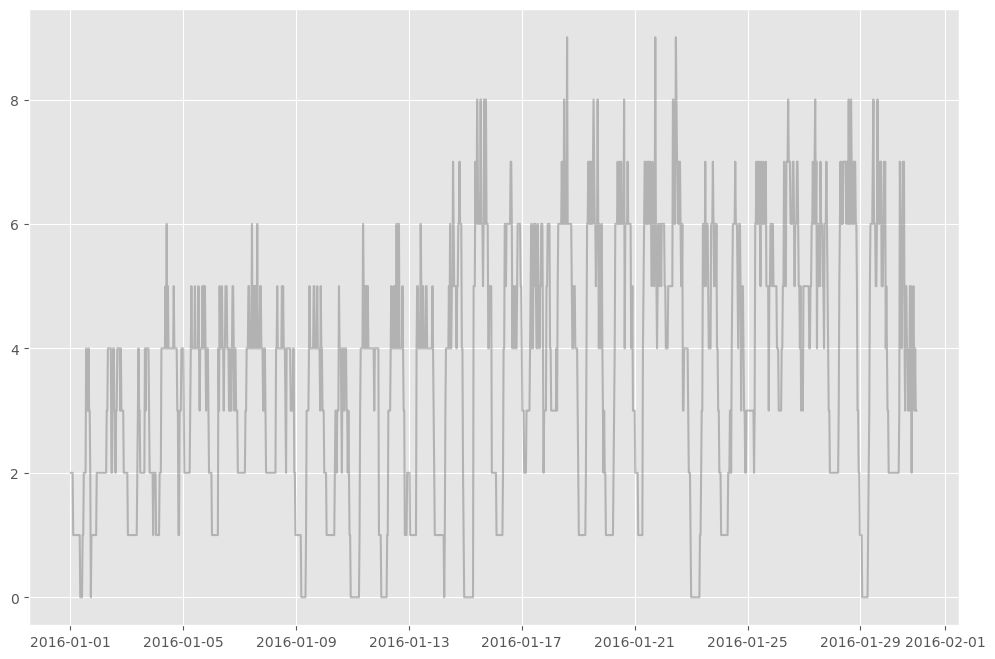

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

KeyboardInterrupt: 

In [31]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(df_sample.Period, df_sample.Sessions.values, label='Real Demand', color='grey', alpha=0.5)
plt.show()
for i in range((len(df_sample)-input_dim)//output_dim):
   X_train = df_sample.iloc[output_dim*i: input_dim + output_dim * i]
   y_train = df_sample.iloc[output_dim*i + input_dim: output_dim*(1+i) + input_dim]
   line1, = ax.plot(X_train.Period, X_train.Sessions.values, label=f'{i}', color='red', alpha=0.5)
   line2, = ax.plot(y_train.Period, y_train.Sessions.values, label=f'{i}', color='green', alpha=0.5)

   plt.draw()
   plt.pause(1)
   line1.remove()
   line2.remove()

In [32]:
poisson = torch.distributions.Poisson(1)

In [3]:
from losses import censored_poisson_negative_log_likelihood
import torch

In [4]:
y_pred = torch.tensor([1.0, 2.0, 3.0, 4.0, 5.0])
y_true = torch.tensor([5.0, 5.0, 5.0, 5.0, 5.0])

censored_poisson_negative_log_likelihood(y_pred, y_true, 2)

tensor(4.8515, dtype=torch.float64)